# GPR model selection

This notebook details the GPR fitting procedure and hyperparamter selection, including the size of the latent dimension and kernel parameters.

## Imports

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import itertools
import sys
import time
from random import shuffle, seed
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 180
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy
import pickle
from sklearn import preprocessing
import random
from sklearn.model_selection import LeaveOneOut, KFold
from scipy.optimize import minimize, minimize_scalar
from sklearn.preprocessing import StandardScaler
from GPR_v2 import GaussianProcessRegressor

Autosaving every 180 seconds


Load in data for the observed mean and uncertainties 

In [9]:
mu_std = np.loadtxt("mu_std.dat")
mu = mu_std[:, 0]
scaler = StandardScaler()
y_scaled = scaler.fit_transform(mu.reshape(-1, 1))
std_scaled = mu_std[:, 1] / np.sqrt(scaler.var_)[0]
names = np.array([
    str(i)[1:]
    for i in np.loadtxt("names_all.dat", dtype="str")
])

In [10]:
print("Total of {} training samples.".format(mu.shape[0]))

Total of 122 training samples.


# Grid Search
Iterate over all VAE dimensions and perform a grid search over the kernel hyperparameter $l$. 

In [12]:
vae_dims = list(range(3,11)) # number of VAE models to test

In [13]:
def sampling(z_mean, z_log_var):
    """
    Reparameterization trick by sampling an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    batch, dim = z_mean.shape
    # by default, random_normal has mean=0 and std=1.0
    epsilon = np.random.normal(size=(batch, dim))
    return z_mean + np.exp(0.5 * z_log_var) * epsilon

Define a scoring for a given value of kernel bandwidth $l$ based on $R^2$ score.

In [8]:
def getGPRScore_kf(z, std, labels, in_indicies, train_inds, test_inds, l):
    latent_dim = z.shape[1]
    initial_input = z[in_indicies[train_inds]].reshape(-1, latent_dim)
    initial_output = labels[train_inds]
    kernel = RBF(length_scale=l)
    alpha_std = std[train_inds]
    regressor = GaussianProcessRegressor(
        kernel=kernel, alpha=alpha_std, optimizer=None)
    regressor.kernel.set_params(length_scale=l)
    regressor.fit(initial_input, initial_output)
    validate = z[in_indicies[test_inds]].reshape(-1, latent_dim)
    validate_output = labels[test_inds].reshape(-1, 1)
    return regressor.score(validate, validate_output)

## Grid search of GPR parameters
Iterate a search over `num_samples` different realization of the latent space, the kernel bandwidth parameter `l`, and the dimension of the latent space `d` using 5-fold cross-validation (CV) $R^2$ score.

In [9]:
total_mean_kf = list()
n_mols = 96
num_samples = 50 # num_samples+1 runs, which includes z_mean
embeddings_kf = dict()
for i in vae_dims:
    vae_dim = list()
    embeddings_kf[str(i)] = list()
    for j in range(num_samples):
        print("Start i = ", i)
        z_mean = np.loadtxt("z_mean_{}.dat".format(i))
        z_logvar = np.loadtxt("z_logvar_{}.dat".format(i))
        if j == 0:
            z = z_mean
        else:
            z = sampling(z_mean, z_logvar)
            embeddings_kf[str(i)].append(z)
        peptide = np.loadtxt("peptide_{}.dat".format(i), dtype="str")
        in_indicies = np.array(
            [np.where(i == peptide[:, 0])[0][0] for i in names])
        kf = KFold(n_splits=5)
        kf.get_n_splits(y_scaled)
        tot = list()
        length_scales_vae = np.geomspace(1e-3, 1e3, 100)
        for l in length_scales_vae:
            l_list = list()
            for train_index, test_index in kf.split(y_scaled):
                l_list.append(
                    getGPRScore_kf(
                        z,
                        std_scaled,
                        y_scaled,
                        in_indicies,
                        train_index,
                        test_index,
                        l=l))
            tot.append(l_list)
        vae_dim.append(tot)
    vae_dim = np.asarray(vae_dim)
    total_mean_kf.append(np.mean(vae_dim, axis=-1))
total_mean_kf = np.asarray(total_mean_kf)

Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  3
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4
Start i =  4

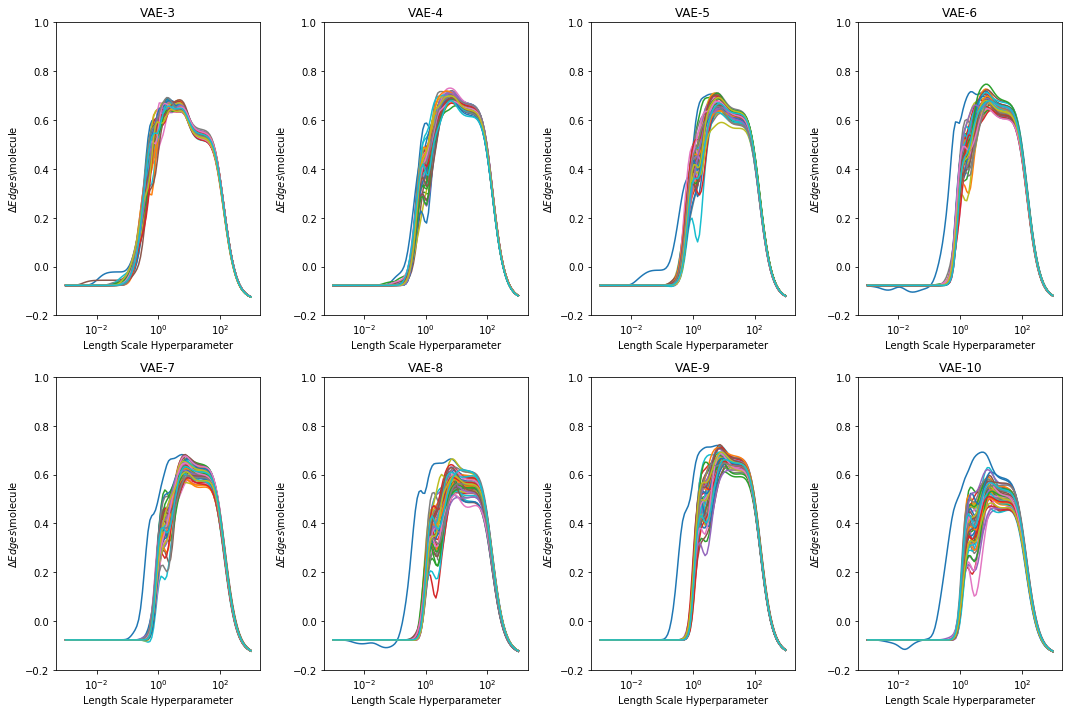

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
k = 0
for row in range(2):
    for col in range(4):
        [
            ax[row, col].semilogx(length_scales_vae, mean)
            for mean in total_mean_kf[k]
        ]
        ax[row, col].set_title("VAE-{}".format(k + 3))
        ax[row, col].set_xlabel("Length Scale Hyperparameter")
        ax[row, col].set_ylabel(r"$\Delta Edges$\molecule")
        ax[row, col].set_ylim(-0.2,1.0)
        k += 1
plt.tight_layout()

## Optimization
Select the best performing latent space and optimize the 5-fold CV score w.r.t the kernel bandwidth `l` for each latent space dimension `d` using the best value from the grid search as a starting point.

In [11]:
optim_param_vae = list()
optim_score_vae = list()
for dim in vae_dims:
    z_sample, _ = np.unravel_index(total_mean_kf[dim - vae_dims[0]][1:].argmax(),
                                   total_mean_kf[dim - vae_dims[0]][1:].shape)
    z = embeddings_kf[str(dim)][z_sample]
    np.savetxt("z_best_d_{}.dat".format(dim),z)
    peptide = np.loadtxt("peptide_{}.dat".format(dim), dtype="str")
    in_indicies = np.array([np.where(i == peptide[:, 0])[0][0] for i in names])

    #loo = LeaveOneOut()
    #loo.get_n_splits(y_scaled)
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(y_scaled)

    x0 = length_scales_vae[np.argmax(total_mean_kf[dim - vae_dims[0]][1:][z_sample])]

    def objFunc_vae(l):
        val = 0.0
        for train_index, test_index in kf.split(y_scaled):
            val += getGPRScore_kf(
                   z,
                   std_scaled,
                   y_scaled,
                   in_indicies,
                   train_index,
                   test_index,
                   l=l)
        #return -1*val / len(y_scaled)/n_mols
        return -1*val/kf.n_splits

    res = minimize(
        objFunc_vae,
        x0,
        options={"disp": True},
        tol=1e-6,
        method='Nelder-Mead')
    optim_param_vae.append(res.x[0])
    optim_score_vae.append(res.fun)
optim_param_vae = np.asarray(optim_param_vae)
optim_score_vae = np.asarray(optim_score_vae)

Optimization terminated successfully.
         Current function value: -0.692961
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -0.731041
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -0.711432
         Iterations: 20
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: -0.747251
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -0.682719
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: -0.665021
         Iterations: 21
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: -0.723315
         Iterations: 21
         Function evaluations: 42
Optimization terminated suc

Given the selected kernel bandwidth `l`, select the VAE latent dimension `d` which maximizes the $R^2$ score (in this case `d=6`).

Text(0.5, 1.0, 'Minimum 5-fold Cross validation score \n (higher is better)')

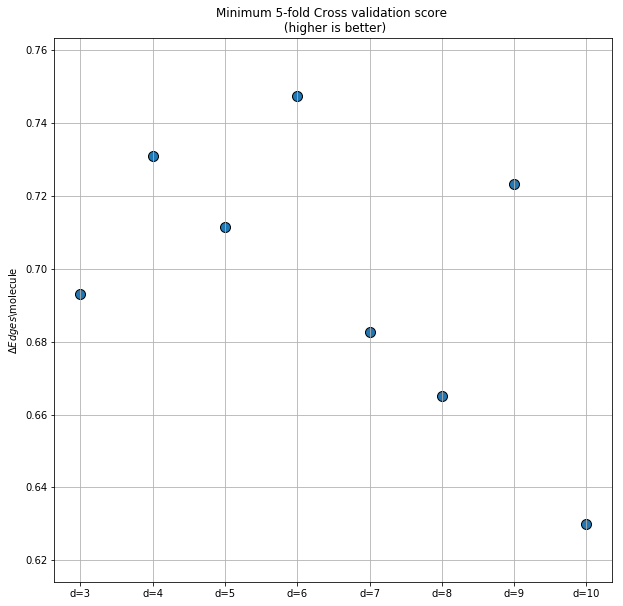

In [12]:
plt.figure(figsize=(10, 10))
plt.grid(True)
plt.rc('grid', linestyle="-.", color='black')
plt.scatter(vae_dims, -optim_score_vae, edgecolors='k', s=100)
_ = plt.xticks(vae_dims,
               ("d=3", "d=4", "d=5", "d=6", "d=7", "d=8", "d=9", "d=10"))
plt.ylabel(r"$\Delta Edges$\molecule")
plt.title("Minimum 5-fold Cross validation score \n (higher is better)")

Save the results to be used by the acquisition function.

In [13]:
print("The standard deviation of the data is: {} edges/molecule".format(
    np.sqrt(scaler.var_)[0] / n_mols))

The standard deviation of the data is: 0.3467358581462581 edges/molecule


In [14]:
print("Best param for vaes (starting with d = 3): {}".format(optim_param_vae))
np.savetxt("optim_param_vae.dat",optim_param_vae)

Best param for vaes (starting with d = 3): [1.97224316 6.180658   6.00482257 7.01154955 7.24627295 7.35435316
 7.35963106 8.05735424]
